## Fitness Tracker Analysis - Part 4

**Continued from Part 3 here:**

`/notebooks/nk-fitness-tracker-p3-feature-engineering.ipynb`

### 4.1 - Predictive Modeling

Using the preprocessed data, the following tasks in this notebook will cover:

- Feature selection
- Model testing and selection
- Hyperparameter tuning with grid search

Towards the end, the model with the highest accuracy will be selected as the final model.

Set up the project below:

In [1]:
# Load the necessary libraries
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from src.models.LearningAlgorithms import ClassificationAlgorithms

In [2]:
# Configure the plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [3]:
import os
os.getcwd()


'/Users/nkeblawi/Projects/nk-fitness-tracker'

In [4]:
# Read in the processed data file
df = pd.read_pickle("data/interim/03_data_preprocessed.pkl")

### 4.2 - Split the Data Into Training and Test Sets

First, remove features we don't need - such as participant, category, and set:

In [5]:
df_train = df.drop(["participant", "category", "set"], axis=1)

Given that `label` is the target variable, drop that column from the training set and assign it to the variable `y`:

In [6]:
X = df_train.drop("label", axis=1)
y = df_train["label"]

Then split the dataset into a training set and a test set using a 75/25 ratio. Be sure to set the `random_state` to an integer for reproducibility.

Also set stratify to `y` to ensure that the label distribution is equal in both training and test sets to minimize bias.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Next, double check that the distribution of the labels is roughly equal in the training and test sets:

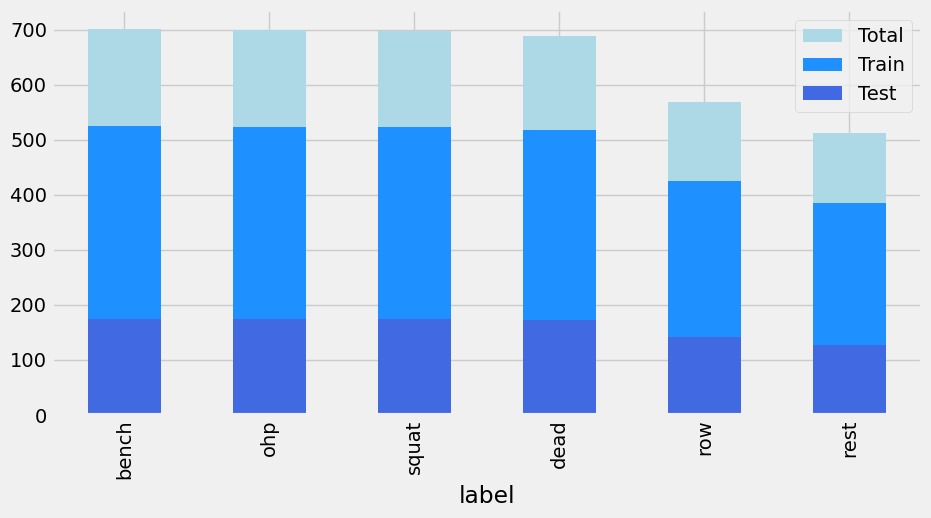

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(
    kind="bar", ax=ax, color="lightblue", label="Total"
)
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.legend()
plt.show()

### 4.3 - Create Feature Groups to Test Models With

In the full dataset, we have over a hundred features and it's not yet known which feature engineering methods are most beneficial. Instead of lumping all features into the model, we'll test each group to see which methods helped the models the most. 

The feature groups are as follows:

- **Original features:** Original six predictor columns (x, y, z) of accelerometer and gyroscope data.

- **Scalar features:** The scalars of accelerometer and gyroscope motions.

- **PCA features:** The components derived from the Principal Component Analysis dimensionality reduction technique.

- **Temporal features:** The rolling averages on the basic and scalar features, as well as standard deviations for each rolling window.

- **Frequency features:** The frequency components of the original and scalar features using Discrete Fourier Transformation.

- **Cluster features:** A cluster feature derived from the KMeans model.

For a review on these methods, please see `/notebooks/nk-fitness-tracker-p3-feature-engineering.ipynb`


In [9]:
# Group the feature columns into feature subsets:
orig_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]
scalar_features = ["acc_r", "gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
frequency_features = [f for f in df_train.columns if ("_freq" in f) or ("_pse" in f)]
cluster_features = ["cluster"]

Check how many features are in each subset:

In [10]:
print("Original features: ", len(orig_features))
print("Scalar features: ", len(scalar_features))
print("PCA features: ", len(pca_features))
print("Time features: ", len(time_features))
print("Frequency features: ", len(frequency_features))
print("Cluster features: ", len(cluster_features))

Original features:  6
Scalar features:  2
PCA features:  3
Time features:  16
Frequency features:  88
Cluster features:  1


Now group features into four sets:

In [11]:
feature_set_1 = list(set(orig_features))
feature_set_2 = list(set(feature_set_1 + scalar_features + pca_features))
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + frequency_features + cluster_features))

### 4.4 - Forward Feature Selection

Now we'll find the 10 best features to use in the model using a decision tree by looping through the full dataset.

In [12]:
# Create an instance of the ClassificationAlgorithms class
learner = ClassificationAlgorithms()

# Set the maximum number of features for selection
max_features = 10

Run the decision tree algorithm (only need to be run once).

**Warning: This will take a long time to run (around 5-7 minutes)**

In [13]:
# selected_features, ordered_features, ordered_scores = learner.forward_selection(
#     max_features, X_train, y_train
# )

Now check which features have been found to be the best and display their scores on a graph:

In [14]:
# ordered_features

In [15]:
# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(1, max_features + 1, 1), ordered_scores)
# plt.xlabel("Number of features")
# plt.ylabel("Accuracy")
# plt.xticks(np.arange(1, max_features + 1, 1))
# plt.show()

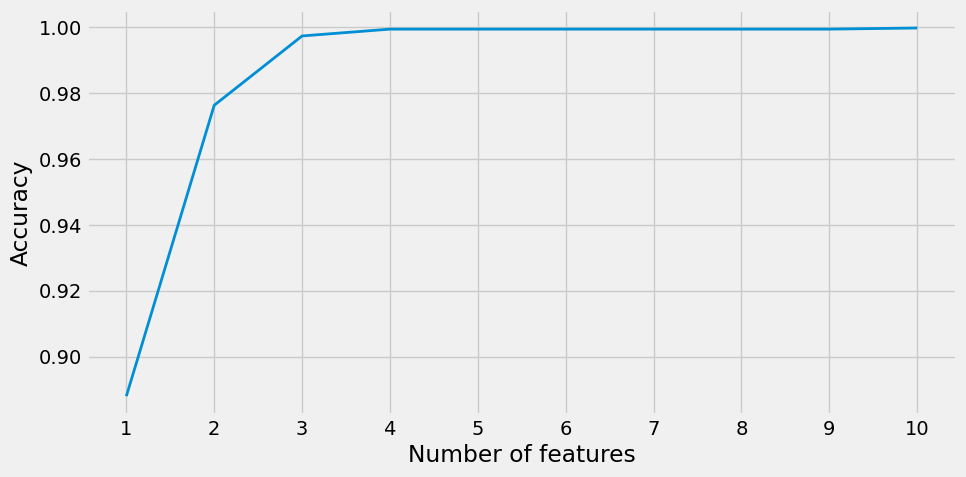

It appears that the PCA and Fourier Transformation methods created very powerful features that brings accuracy close to 100% within just a few features. We'll use these 10 features as the selected group in modeling. 

In [16]:
selected_features = [
    'pca_1',
    'set_duration',
    'acc_x_freq_0.0_Hz_ws_14',
    'acc_y_freq_0.0_Hz_ws_14',
    'acc_z_freq_0.357_Hz_ws_14',
    'acc_r_max_freq',
    'gyr_r_freq_2.5_Hz_ws_14',
    'acc_r_freq_weighted',
    'acc_z_temp_mean_ws_5',
    'gyr_x_pse'
 ]

### 4.5 - Hyperparameter Grid Search

Now run a grid search on the best hyperparameters on all models EXCEPT Neural Networks and XGBoost.

First group each feature set and name them:

In [17]:
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    selected_features,
]

feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Feature Set 4",
    "Selected Features",
]

Now execute the grid search and obtain the scores:

**This cell will run for a while, give it a few minutes...**

In [18]:
iterations = 1
score_df = pd.DataFrame()

for i, f in zip(range(len(possible_feature_sets)), feature_names):

    print("Feature set:", str(i + 1))
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    print("\tTraining XGBoost")
    # First encode the labels in the train_y table
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_train)
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.xgboost_classifier(
        selected_train_X, y_encoded, selected_test_X
    )  # add gridsearch later

    class_test_y = le.inverse_transform(class_test_y)
    performance_test_xgb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB", "XGB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
                performance_test_xgb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
Feature set: 5
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost


Show and compare results in a grouped bar plot:

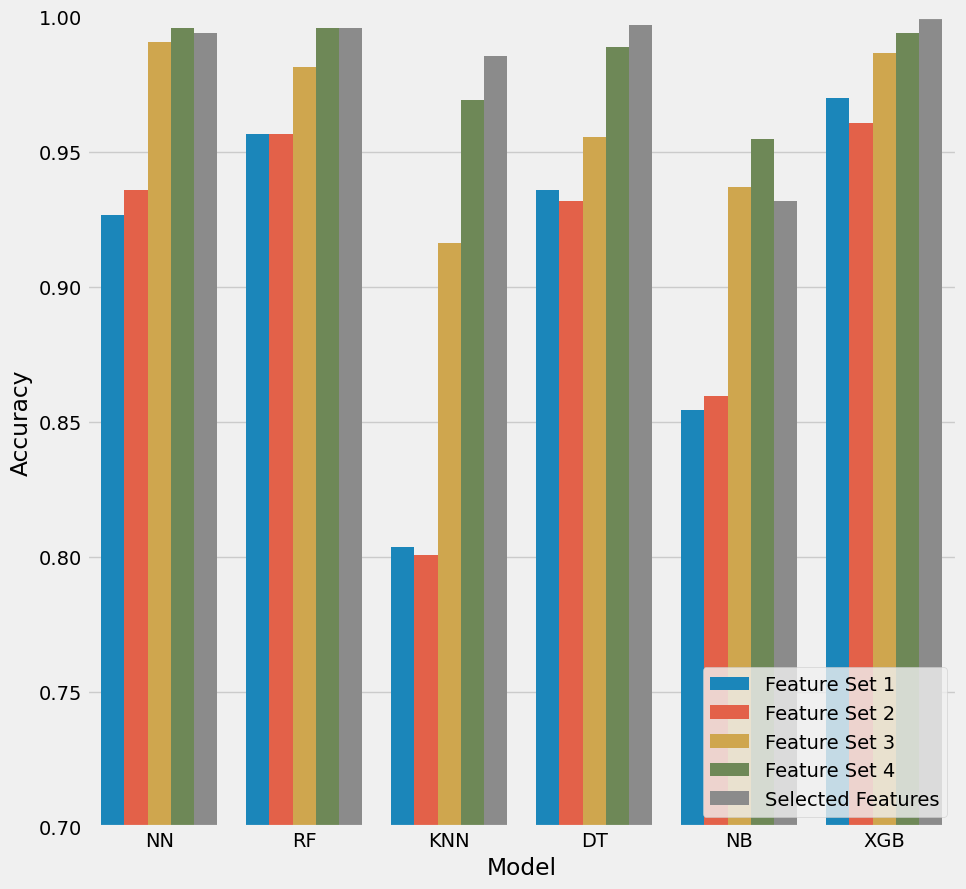

In [19]:
score_df.sort_values(by="accuracy", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=score_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.legend(loc="lower right")
plt.show()

Plot shows that the decision tree model performs best with the selected features. Test the DT model using the test set with the selected features to see how well it generalizes to unfamiliar data.

**Update - XGBoost model performed very well with selected features even without a grid search**

### 4.6 - Compare Model Performance Using Confusion Matrix

To be continued...